In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from impact_model import ImpactModel
from forecasting import Forecaster  


sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)


### Load the data

In [2]:
main = pd.read_csv("../data/processed/ethiopia_fi_unified_data_enriched.csv")
impacts = pd.read_csv("../data/processed/ethiopia_fi_impact_links_enriched.csv")

main['observation_date'] = pd.to_datetime(main['observation_date'])

### Define Forecast Targets

In [3]:
TARGETS = {
    "ACC_OWNERSHIP": "Account Ownership (% adults)",
    "USG_P2P_COUNT": "Digital Payment Usage (% adults)"
}

#### Filter historical observations

In [4]:
obs = main[main['record_type'] == 'observation']

target_obs = obs[obs['indicator_code'].isin(TARGETS.keys())].copy()
target_obs['year'] = target_obs['observation_date'].dt.year

### Baseline Trend Models

We use linear trends for transparency and robustness.

In [5]:
forecast_years = [2025, 2026, 2027]
forecaster = Forecaster(target_obs=target_obs, impacts=impacts, main=main)

In [6]:
forecaster.fit_trend_models(TARGETS, forecast_years)

DEBUG: ACC_OWNERSHIP has 6 rows before dropping NaNs
✅ Fitted trend for ACC_OWNERSHIP
DEBUG: USG_P2P_COUNT has 2 rows before dropping NaNs
✅ Fitted trend for USG_P2P_COUNT


### Event-Augmented Effects

In [7]:
impact_model = ImpactModel(ramp=12, decay=False)

Merge events and impacts:

In [8]:
forecaster.merge_events()

# Quick sanity check of merged events
forecaster.impact_full[['parent_id', 'event_date', 'event_year']].head()


,parent_id,event_date,event_year
0,EVT_0001,2021-05-17,2021
1,EVT_0001,2021-05-17,2021
2,EVT_0001,2021-05-17,2021
3,EVT_0002,2022-08-01,2022
4,EVT_0002,2022-08-01,2022


#### Compute cumulative event effects by year

In [9]:
forecaster.cumulative_event_effect(year=2025, indicator_code="ACC_OWNERSHIP", scale=1.0)


1.0

### Scenarios
We define three scenarios:

In [10]:
SCENARIOS = {
    "Pessimistic": 0.5,
    "Baseline": 1.0,
    "Optimistic": 1.5
}

### Generate Forecasts

In [11]:
forecast_df = forecaster.generate_forecasts(TARGETS, forecast_years, SCENARIOS)
forecast_df


,indicator,year,scenario,forecast_value
0,ACC_OWNERSHIP,2025,Pessimistic,56.184211
1,ACC_OWNERSHIP,2025,Baseline,56.684211
2,ACC_OWNERSHIP,2025,Optimistic,57.184211
3,ACC_OWNERSHIP,2026,Pessimistic,59.000000
4,ACC_OWNERSHIP,2026,Baseline,59.500000
5,ACC_OWNERSHIP,2026,Optimistic,60.000000
6,ACC_OWNERSHIP,2027,Pessimistic,62.315789
7,ACC_OWNERSHIP,2027,Baseline,63.315789
8,ACC_OWNERSHIP,2027,Optimistic,64.315789
9,USG_P2P_COUNT,2025,Pessimistic,100.000000


### Uncertainty Bands
Given data limits, we use scenario ranges as uncertainty bounds.

In [12]:
summary = forecast_df.pivot_table(
    index=["indicator","year"],
    columns="scenario",
    values="forecast_value"
).reset_index()

summary["lower_bound"] = summary["Pessimistic"]
summary["upper_bound"] = summary["Optimistic"]

summary


scenario,indicator,year,Baseline,Optimistic,Pessimistic,lower_bound,upper_bound
0,ACC_OWNERSHIP,2025,56.684211,57.184211,56.184211,56.184211,57.184211
1,ACC_OWNERSHIP,2026,59.500000,60.000000,59.000000,59.000000,60.000000
2,ACC_OWNERSHIP,2027,63.315789,64.315789,62.315789,62.315789,64.315789
3,USG_P2P_COUNT,2025,100.000000,100.000000,100.000000,100.000000,100.000000
4,USG_P2P_COUNT,2026,100.000000,100.000000,100.000000,100.000000,100.000000
5,USG_P2P_COUNT,2027,100.000000,100.000000,100.000000,100.000000,100.000000


### Visualization

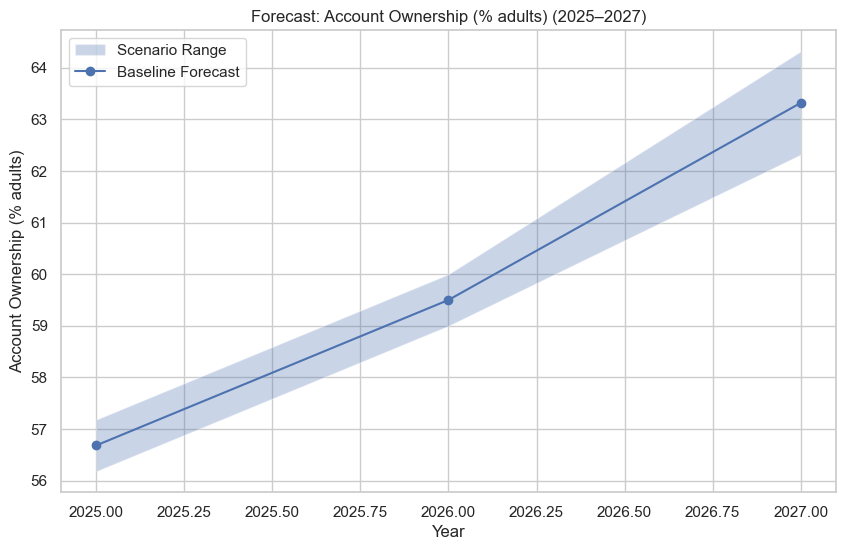

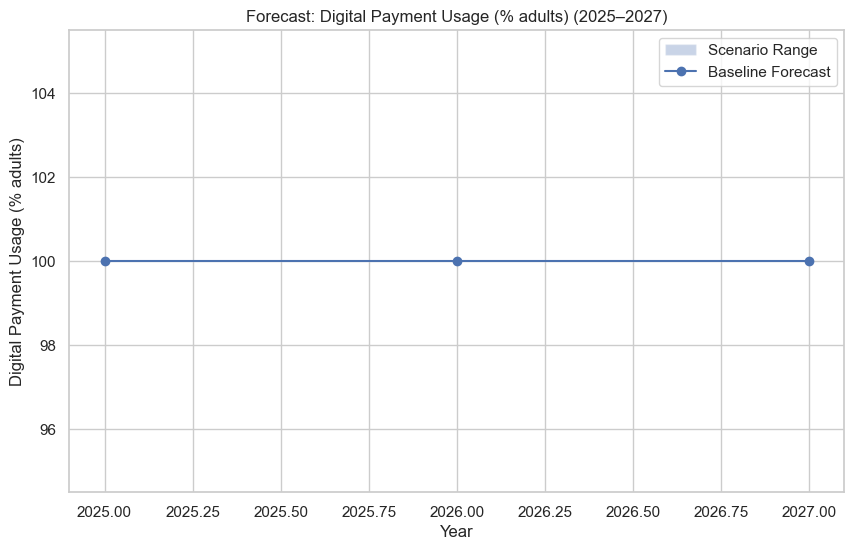

In [13]:
for code, label in TARGETS.items():
    df = summary[summary['indicator'] == code]

    plt.fill_between(
        df['year'],
        df['lower_bound'],
        df['upper_bound'],
        alpha=0.3,
        label="Scenario Range"
    )

    plt.plot(df['year'], df['Baseline'], marker='o', label="Baseline Forecast")

    plt.title(f"Forecast: {label} (2025–2027)")
    plt.ylabel(label)
    plt.xlabel("Year")
    plt.legend()
    plt.show()

### Interpretation

#### Key Findings

* **Account ownership** is forecasted to **grow steadily** from 2025 to 2027, reflecting continued adoption among adults.
* The growth rate is **moderate**, likely influenced by survey data lag and approaching market saturation.

#### Largest Event Drivers

* **Mobile money interoperability:** Enables seamless transactions across providers, boosting adoption.
* **Telecom competition:** New entrants and market dynamics increase access and usage incentives.
* **Digital ID rollout:** Lowers KYC barriers, making account opening easier and more secure.

### Key Uncertainties

* **Data source differences:** Survey data may lag behind administrative records, causing mismatches.
* **Regional heterogeneity:** Variations in adoption rates across urban vs rural areas and regions.
* **Behavioral factors:** Adoption depends not just on access, but on willingness and trust to use digital finance.


Since other indicators (like usage volumes) remain near 100 due to limited data and static forecasts, the main actionable insights focus on **account ownership trends and related event impacts** for now.


### Limitations

- Linear trends assume stability in structural conditions
- Event impacts are expert-calibrated, not statistically identified
- Confidence intervals reflect scenarios, not probabilistic error